In [85]:
import pandas as pd
import numpy as np
import yaml
from pypsa.descriptors import Dict
import os
import yaml
from math import radians, cos, sin, asin, sqrt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def load_configuration(config_path):
    """
    Load configuration settings from a YAML file.
    """
    with open(config_path, "r") as f:
        config = yaml.safe_load(f)
    return config


snakemake = Dict()
snakemake.config = load_configuration("../config.yaml")
snakemake.input = Dict()
snakemake.output = Dict()

run = "paper-scenariomanager-fixed"  # run name from config.yaml

folder = f"/results/{run}"

In [3]:
def calculate_distance(n, bus1, bus2):
    """
    Calculate the great circle distance between two buses in a PyPSA network object using the Haversine formula.

    Parameters:
    n (DataFrame): PyPSA network object containing bus coordinates.
    bus1 (str): The ID of the first bus.
    bus2 (str): The ID of the second bus.

    Returns:
    float: The distance between the two buses in kilometers.
    """

    def haversine(lon1, lat1, lon2, lat2):
        """
        Calculate the great circle distance between two points on the earth (specified in decimal degrees)
        """
        # Convert decimal degrees to radians
        lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
        c = 2 * asin(sqrt(a))
        r = 6371  # Radius of earth in kilometers.
        return c * r

    # Extract the coordinates of the two buses
    lon1, lat1 = n.buses.loc[bus1, ["x", "y"]]
    lon2, lat2 = n.buses.loc[bus2, ["x", "y"]]

    # Calculate the distance using the Haversine formula
    distance_km = haversine(lon1, lat1, lon2, lat2)

    return distance_km

In [4]:
with open("../custom_config.yaml", "r") as f:
    # datacenters = yaml.safe_load(f)["ci"][f"{distance}"]["datacenters"]
    scenarios = yaml.safe_load(f)["scenario"]["distance"]

flexibilities = snakemake.config["scenario"]["flexibility"]

In [11]:
data = []

for scenario in scenarios:
    for flexibility in flexibilities:
        file_path = (
            f"../{folder}/summaries/2025/p1/cfe100/{scenario}/{flexibility}.yaml"
        )
        with open(file_path, "r") as f:
            summary = yaml.safe_load(f)

            # Initialize variables for calculating averages and sums
            total_ci_average_cost = 0
            total_ci_total_cost = 0
            num_locations = 0

            # Assuming summary is a dictionary of dictionaries
            for location, values in summary.items():
                # Ensure 'values' is a dictionary and contains the expected keys
                if (
                    isinstance(values, dict)
                    and "ci_average_cost" in values
                    and "ci_total_cost" in values
                ):
                    total_ci_average_cost += values["ci_average_cost"]
                    total_ci_total_cost += values["ci_total_cost"]
                    num_locations += 1

            avg_ci_average_cost = total_ci_average_cost / 3
            normalized_ci_total_cost = total_ci_total_cost / (300 * 8760)

            data.append(
                (scenario, flexibility, avg_ci_average_cost, normalized_ci_total_cost)
            )

# Construct DataFrame
df = pd.DataFrame(
    data,
    columns=["Scenario", "Flexibility", "CI_Average_Cost", "CI_Total_Cost_Normalized"],
)
df.set_index(["Scenario", "Flexibility"], inplace=True)

df = df.round(2).reset_index()

In [84]:
df

,Scenario,Flexibility,CI_Average_Cost,CI_Total_Cost_Normalized
0,DKIENL,0,205.93,205.92
1,DKIENL,10,185.35,185.34
2,DKIENL,20,167.77,167.77
3,DKIENL,30,152.30,152.30
4,DKIENL,40,140.20,140.20
...,...,...,...,...
270,FRGRPT,0,178.53,178.53
271,FRGRPT,10,164.10,164.09
272,FRGRPT,20,151.26,151.26
273,FRGRPT,30,141.12,141.13


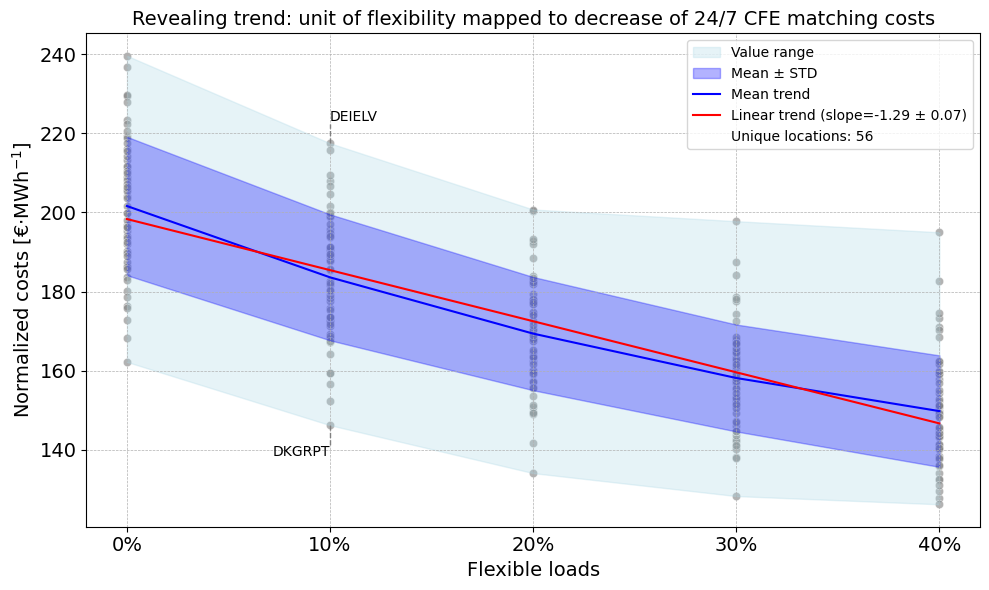

In [83]:
from scipy import stats


def plot_flexibility_vs_normalized_costs(df):
    # Ensure Flexibility and Cost_per_MWh are numeric
    df["Flexibility"] = pd.to_numeric(df["Flexibility"], errors="coerce")
    df["CI_Average_Cost"] = pd.to_numeric(df["CI_Average_Cost"], errors="coerce")

    # Calculate mean and confidence interval (or standard deviation) for each flexibility level
    mean_costs = df.groupby("Flexibility")["CI_Average_Cost"].mean()
    std_costs = df.groupby("Flexibility")["CI_Average_Cost"].std()
    min_costs = df.groupby("Flexibility")["CI_Average_Cost"].min()
    max_costs = df.groupby("Flexibility")["CI_Average_Cost"].max()

    # Linear regression for trend line
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        df["Flexibility"].dropna(), df["CI_Average_Cost"].dropna()
    )

    # Plotting
    plt.figure(figsize=(10, 6))

    # Scatter plot for individual observations
    sns.scatterplot(
        x="Flexibility", y="CI_Average_Cost", data=df, color="grey", alpha=0.6
    )

    # Shaded area for the distribution (value range)
    plt.fill_between(
        mean_costs.index,
        min_costs.values,
        max_costs.values,
        color="lightblue",
        alpha=0.3,
        label="Value range",
    )

    # Shaded area around the average trend (mean ± std)
    std_label = "Mean ± STD"
    plt.fill_between(
        mean_costs.index,
        (mean_costs - std_costs).values,
        (mean_costs + std_costs).values,
        color="blue",
        alpha=0.3,
        label=std_label,
    )

    # Line plot for the average trend
    plt.plot(mean_costs.index, mean_costs.values, color="blue", label="Mean trend")

    # Linear trend line with slope ± std in the legend
    linear_trend_label = f"Linear trend (slope={slope:.2f} ± {std_err:.2f})"
    plt.plot(
        df["Flexibility"],
        intercept + slope * df["Flexibility"],
        "r",
        label=linear_trend_label,
    )

    # Customizing the plot
    plt.title(
        f"Revealing trend: unit of flexibility mapped to decrease of 24/7 CFE matching costs",
        fontsize=14,
    )
    plt.xlabel("Flexible loads", fontsize=14)
    plt.ylabel("Normalized costs [€$\cdot$MWh$^{-1}$]", fontsize=14)
    plt.xticks(
        ticks=mean_costs.index, labels=[f"{x}%" for x in mean_costs.index], fontsize=14
    )
    plt.yticks(fontsize=14)
    plt.grid(True, which="major", linestyle="--", linewidth=0.5)
    plt.legend()
    plt.tight_layout()

    # unique locations
    unique_locations = (
        len(df["Scenario"].unique()) + 1
    )  # Adjusted as per your instruction
    plt.plot([], [], " ", label=f"Unique locations: {unique_locations}")
    plt.legend()

    ## Add labels for max and min values
    selected_flexibility_df = df[df["Flexibility"] == 10]

    # Identify the scenarios for the max and min CI_Average_Cost values at the selected flexibility
    max_value_scenario = selected_flexibility_df.loc[
        selected_flexibility_df["CI_Average_Cost"].idxmax(), "Scenario"
    ]
    min_value_scenario = selected_flexibility_df.loc[
        selected_flexibility_df["CI_Average_Cost"].idxmin(), "Scenario"
    ]
    # Get the max and min CI_Average_Cost values and their corresponding Flexibility value for positioning the labels
    max_cost = selected_flexibility_df["CI_Average_Cost"].max()
    min_cost = selected_flexibility_df["CI_Average_Cost"].min()
    flexibility_value = 10
    # Coordinates for max and min points
    max_cost_x = flexibility_value
    max_cost_y = max_cost
    min_cost_x = flexibility_value
    min_cost_y = min_cost
    # Coordinates for labels
    label_offset = 5
    max_label_y = max_cost_y + label_offset
    min_label_y = min_cost_y - label_offset
    # Add text labels for the max and min values on the plot
    plt.text(
        max_cost_x, max_label_y, max_value_scenario, ha="left", va="bottom"
    )  # Adjust ha and va as needed
    plt.text(
        min_cost_x, min_label_y, min_value_scenario, ha="right", va="top"
    )  # Adjust ha and va as needed
    # Draw lines connecting labels to the dots
    plt.plot(
        [max_cost_x, max_cost_x],
        [max_cost_y, max_label_y],
        color="grey",
        linestyle="--",
        linewidth=1,
    )
    plt.plot(
        [min_cost_x, min_cost_x],
        [min_cost_y, min_label_y],
        color="grey",
        linestyle="--",
        linewidth=1,
    )

    # Show plot
    # plt.show()
    plt.savefig("../manuscript/img/flexibility_vs_normalized_costs.pdf")


# After defining this function, call it with you

plot_flexibility_vs_normalized_costs(df)